In [13]:
import day20
#reload(day20);

import networkx as nx
import matplotlib.pyplot as plt

from math import sqrt
from itertools import product
from day20 import *
from networkx.algorithms import weakly_connected_components
from test_day20 import tiles, edge_lookup


In [17]:
with open('./test_input.txt', 'r') as f:
    raw = f.read()
    tiles = create_tiles(raw)

All cells can be rotated into one of 4 directions, flipped l-r and flipped u-d

In [18]:
def create_all_tile_orientations(tiles):
    all_tile_orientations = {}
    for raw_tid, tile in tiles.items():
        for rot in range(4):
            all_tile_orientations[(raw_tid, rot, 'none')] = np.rot90(tile, rot)
            all_tile_orientations[(raw_tid, rot, 'lr')] = np.fliplr(np.rot90(tile, rot))
            # Don't need to use flipud because the combination of flips and rotations
            # above already covers these outputs
    return all_tile_orientations

all_tile_orientations = create_all_tile_orientations(tiles)
len(all_tile_orientations)

72

Create the edge lookup 

In [19]:
def create_edge_lookup(ato):
    edge_lookup = defaultdict(list)
    for k, tile in ato.items():
        top, left, right, bottom = get_tile_edges(tile)
        edge_lookup[top].append((*k, "top"))
        edge_lookup[left].append((*k, "left"))
        edge_lookup[right].append((*k, "right"))
        edge_lookup[bottom].append((*k, "bottom"))

    return edge_lookup

edge_lookup = create_edge_lookup(all_tile_orientations)
edge_lookup['..##.#..#.']

[('2311', 0, 'none', 'top'),
 ('2311', 2, 'lr', 'bottom'),
 ('2311', 3, 'none', 'right'),
 ('2311', 3, 'lr', 'left'),
 ('1427', 0, 'none', 'bottom'),
 ('1427', 2, 'lr', 'top'),
 ('1427', 3, 'none', 'left'),
 ('1427', 3, 'lr', 'right')]

Create the network

In [20]:
G = nx.DiGraph()

for k, edge_list in edge_lookup.items():
    for src, dst in product(edge_list, edge_list):
        if src[0] != dst[0]: # no self-loops
            if (src[-1] == "bottom" and dst[-1] == "top"):
                G.add_edge(src[0:3], dst[0:3], label="bt")
            elif (src[-1] == "right" and dst[-1] == "left"):
                G.add_edge(src[0:3], dst[0:3], label="rl")

for idx, comp in enumerate(sorted(weakly_connected_components(G), 
                           key=lambda nodes: sum(x[1] for x in G.subgraph(nodes).nodes))):
    sub_G = G.subgraph(comp).copy()
    nx.nx_agraph.write_dot(sub_G, f"./out/the-graph-{idx}.dot")
    print(sub_G.in_degree, "\n====================")

[(('2971', 0, 'none'), 0), (('1427', 0, 'none'), 2), (('2729', 0, 'none'), 1), (('1489', 0, 'none'), 1), (('2473', 3, 'none'), 2), (('1171', 2, 'none'), 1), (('3079', 2, 'lr'), 2), (('1951', 0, 'none'), 1), (('2311', 0, 'none'), 2)] 
[(('3079', 2, 'none'), 1), (('1427', 0, 'lr'), 2), (('2729', 0, 'lr'), 2), (('2473', 3, 'lr'), 1), (('1489', 0, 'lr'), 1), (('1171', 2, 'lr'), 0), (('1951', 0, 'lr'), 2), (('2311', 0, 'lr'), 2), (('2971', 0, 'lr'), 1)] 
[(('2729', 1, 'none'), 2), (('2473', 0, 'none'), 1), (('2971', 1, 'none'), 1), (('1427', 1, 'none'), 2), (('1171', 3, 'none'), 0), (('2311', 1, 'none'), 2), (('3079', 1, 'lr'), 1), (('1951', 1, 'none'), 2), (('1489', 1, 'none'), 1)] 
[(('2473', 0, 'lr'), 1), (('2971', 1, 'lr'), 2), (('1427', 1, 'lr'), 2), (('1171', 3, 'lr'), 1), (('2311', 1, 'lr'), 1), (('1951', 1, 'lr'), 1), (('2729', 1, 'lr'), 2), (('1489', 1, 'lr'), 2), (('3079', 1, 'none'), 0)] 
[(('1427', 2, 'lr'), 2), (('2311', 2, 'lr'), 1), (('2729', 2, 'lr'), 1), (('1489', 2, 'lr'),

This will give a number of different combinations - which are all equivalent.  We'll pick the first one with the least amount of sorting in 

In [21]:
sub_G = G.subgraph(min(weakly_connected_components(G), key=lambda nodes: sum(x[1] for x in G.subgraph(nodes).nodes))).copy()

## We can now answer Part A at this point, but looking for the nodes with degree == 2

In [22]:
corner_ids = [ int(n[0]) for n in sub_G.nodes if sub_G.degree(n) == 2 ]
corner_ids, corner_ids[0] * corner_ids[1] * corner_ids[2] * corner_ids[3] 

([2971, 1171, 3079, 1951], 20899048083289)

## Part B

Now we take sub_G, find the top left corner, and fill in the final image by iterating left then down

In [25]:
first_tile = [ x for x in sub_G.nodes if sub_G.in_degree(x) == 0 ]
assert len(first_tile) == 1
first_tile_in_col = first_tile[0]
first_tile_in_col

('2971', 0, 'none')

In [26]:
def get_next_rl_node(G, n):
    out_edges = G.out_edges(n, data=True)
    rlist = [ dst for src, dst, attr in list(out_edges) if attr['label'] == "rl" ]
    assert len(rlist) < 2
    return rlist[0] if len(rlist) == 1 else None

def get_next_bt_node(G, n):
    out_edges = G.out_edges(n, data=True)
    rlist = [ dst for src, dst, attr in list(out_edges) if attr['label'] == "bt" ]
    assert len(rlist) < 2
    return rlist[0] if len(rlist) == 1 else None

In [168]:
#del tile

# Reset the loop
first_tile_in_col = first_tile[0]
tile_shape = tiles[first_tile_in_col[0]].shape
grid_size = int(sqrt(len(tiles)))
image_shape = tuple(map(lambda x: x * grid_size, tile_shape))
image = np.full(image_shape, "/")
print(f"Image size = {image_shape}, {image.shape}")

row_idx = 0
while first_tile_in_col:
    this_tile_info = first_tile_in_col
    col_idx = 0
    while this_tile_info:
        print(this_tile_info, f"\trow={row_idx}, col={col_idx}")
        this_tid = this_tile_info[0]
        
        this_tile = np.rot90(tiles[this_tid], int(this_tile_info[1]))

        if this_tile_info[2] == "lr":
            this_tile = np.fliplr(this_tile)

        #this_tile[np.where(this_tile == ".")] = 0
        #this_tile[np.where(this_tile == "#")] = 1
        #this_tile = this_tile.astype(int)

        # Now we insert the tile into the image at the appropriate co-ordinates
        image_slice = image[
            (row_idx * tile_shape[1]):((row_idx+1)*tile_shape[1]),
            (col_idx * tile_shape[0]):((col_idx+1)*tile_shape[0])
        ]
        assert this_tile.shape == image_slice.shape, (tile.shape, image_slice.shape)
        del image_slice # this was just used for a size check

        image[
            (row_idx * tile_shape[1]):((row_idx+1)*tile_shape[1]),
            (col_idx * tile_shape[0]):((col_idx+1)*tile_shape[0])
        ] = this_tile

        # Output the image for debugging - note index positions
        # plt.matshow(image).get_figure().savefig(f"out/figure-{row_idx}-{col_idx}.png")

        # Move to next row
        this_tile_info = get_next_rl_node(sub_G, this_tile_info)
        col_idx += 1

    # move to next row
    first_tile_in_col = get_next_bt_node(sub_G, first_tile_in_col)
    row_idx += 1

Image size = (30, 30), (30, 30)
('2971', 0, 'none') 	row=0, col=0
('1489', 0, 'none') 	row=0, col=1
('1171', 2, 'none') 	row=0, col=2
('2729', 0, 'none') 	row=1, col=0
('1427', 0, 'none') 	row=1, col=1
('2473', 3, 'none') 	row=1, col=2
('1951', 0, 'none') 	row=2, col=0
('2311', 0, 'none') 	row=2, col=1
('3079', 2, 'lr') 	row=2, col=2


In [169]:
assert grid_size - 1 == sum(np.array_equal(image[idx, :], image[idx + 1, :]) for idx in range(0, image.shape[0] - 1))
assert grid_size - 1 == sum(np.array_equal(image[:, idx], image[:, idx + 1]) for idx in range(0, image.shape[0] - 1))

Now remove the tile borders, these will be at 9,10, 19,20, etc.

In [170]:
for idx in np.arange(image.shape[0], -1, -this_tile.shape[0]):
    try:
        # image[idx, :] = f"{idx/10}" # Row
        image = np.delete(image, idx, axis=0)
    except IndexError:
        pass
    try:
        # image[:, idx] = f"B{idx}"
        image = np.delete(image, idx, axis=1)
    except IndexError:
        pass
    try:
        if idx > 0:
            #image[idx - 1, :] = f"{idx/10}" # Row
            image = np.delete(image, idx-1, axis=0)
    except IndexError:
        pass
    try:
        if idx > 0:
            # image[:, idx - 1] = f"D{idx}"
            image = np.delete(image, idx-1, axis=1)
    except IndexError:
        pass


In [171]:
for arr in image:
    print("".join(arr))

...###...##...#...#..###
.#.###..##..##..####.##.
#.##..#..#...#..####...#
#####..#####...###....##
#..####...#.#.#.###.###.
..#.#..#..#.#.#.####.###
.####.###.#...###.#..#.#
.#.#.###.##.##.#..#.##..
###.#...#..#.##.######..
.#.#....#.##.#...###.##.
...#..#..#.#.##..###.###
##..##.#...#...#.#.#.#..
#.####....##..########.#
###.#.#...#.######.#..##
#.####..#.####.#.#.###..
#..#.##..#..###.#.##....
.####...#..#.....#......
....#..#...##..#.#.###..
...########.#....#####.#
##.#....#.##.####...#.##
###.#####...#.#####.#..#
##.##.###.#.#..######...
###....#.#....#..#......
.#.#..#.##...#.##..#####


In [207]:
def display_image(image):
    image = np.copy(image)
    image[np.where(image == "#")] = 1
    image[np.where(image == ".")] = 0
    image[np.where(image == "O")] = 2
    plt.imshow(image.astype(int))

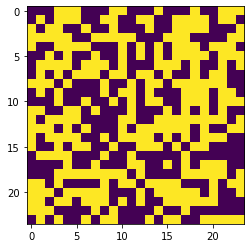

In [173]:
display_image(image)

### Check for monsters!

In [174]:
monster_mask = np.array(list(map(lambda x: [ True if c == "#" else False for c in x ], """                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """.splitlines())))

monster_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False],
       [ True, False, False, False, False,  True,  True, False, False,
        False, False,  True,  True, False, False, False, False,  True,
         True,  True],
       [False,  True, False, False,  True, False, False,  True, False,
        False,  True, False, False,  True, False, False,  True, False,
        False, False]])

(0, 303)
(0, 303)
(0, 303)
(0, 303)
(0, 303)
(0, 303)
(2, 273)
(0, 303)


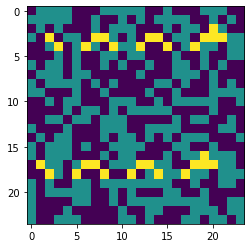

In [208]:
def look_for_monsters(input_image):
    image = np.copy(input_image) # to avoid side effects

    # Look for monsters and mark them with Os where found
    monster_count = 0
    for row_idx in range(image.shape[0] - (monster_mask.shape[0] - 1)):
        for col_idx in range(image.shape[1] - (monster_mask.shape[1] - 1)):
            image_slice = image[
                (row_idx):(row_idx + monster_mask.shape[0]),
                (col_idx):(col_idx + monster_mask.shape[1])
            ]
            
            assert image_slice.shape == monster_mask.shape
            
            if all(image_slice[monster_mask] == "#"):
                image_slice[monster_mask] = "O"
                monster_count += 1

            # Now we need to copy the image_slice back into the image - as it's not actually a view!!
            image[
                (row_idx):(row_idx + monster_mask.shape[0]),
                (col_idx):(col_idx + monster_mask.shape[1])
            ] = image_slice

    if monster_count > 0:
        plt.figure()
        display_image(image)
        
    return monster_count, np.sum(image == "#")

# Need to check rotations/flips of image
for rot in range(0, 4):
    print(look_for_monsters(np.rot90(image, rot)))
    print(look_for_monsters(np.fliplr(np.rot90(image, rot))))

In [199]:
 test_monster = np.copy(monster_mask).astype(str)
 test_monster[monster_mask] = "#"
 test_monster[~monster_mask] = "."
 for arr in test_monster:
     print("".join(arr))

print(look_for_monsters(test_monster))

..................#.
#....##....##....###
.#..#..#..#..#..#...
0 0
(1, 0)
